# Qiskit config

In [1]:
from qiskit import IBMQ, QuantumCircuit, ClassicalRegister, QuantumRegister, execute, transpile
from qiskit.providers.aer.backends import AerSimulator
from qiskit.test.mock import FakeMontreal, FakeMumbai

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research') # 'ibm-q'

from qiskit_ionq import IonQProvider
provider_ionq = IonQProvider()

In [2]:
backend_0  = AerSimulator()
backend_1  = provider.get_backend('ibmq_qasm_simulator')
backend_2  = provider.get_backend('ibmq_santiago')
backend_3  = provider.get_backend('ibmq_manila')
backend_4  = provider.get_backend('ibmq_casablanca')
backend_5  = provider.get_backend('ibmq_jakarta')
backend_6  = provider.get_backend('ibm_lagos')
backend_7  = provider.get_backend('ibmq_bogota')
backend_8  = provider.get_backend('ibm_perth')

backend_9  = FakeMontreal()
backend_10  = FakeMumbai()

backend_11 = provider_ionq.get_backend("ionq_simulator")
backend_12 = provider_ionq.get_backend("ionq_qpu")

shots      = 8192

"""
    Select the backends that will be compared.
"""

backends = [ backend_8  ]

# Experiment procedures

In [3]:
import numpy as np
import sys
import warnings
sys.path.append('../../')
from qclib.state_preparation.schmidt import initialize

warnings.filterwarnings("ignore")

def counts(transpiled_circuit):
    count_ops = transpiled_circuit.count_ops()
    n_cx = 0
    if 'cx' in count_ops:
        n_cx = count_ops['cx']
    n_dp = transpiled_circuit.depth()

    return n_cx, n_dp

def overlap_and_counts(state, r):
    circuit = initialize(state, r)
    transpiled_circuit = transpile(circuit, basis_gates=['u1','u2','u3', 'cx'], optimization_level=3)
    backend = AerSimulator()
    transpiled_circuit.save_statevector()
    ket = backend.run(transpiled_circuit).result().get_statevector()
    bra = np.conj(state)

    n_cx, n_dp = counts(transpiled_circuit)

    return np.abs(bra.dot(ket))**2, n_cx, n_dp

def measurement(circuit, c):
    n = len(c)
    circuit.measure(list(range(n)), c)

    job = execute(circuit, backend, shots=shots, optimization_level=3)
    
    counts = job.result().get_counts(circuit)
    v = sum(counts.values())
    
    counts2 = {}
    for m in range(2**n):
        pattern = '{:0{}b}'.format(m, n)
        if pattern in counts:
            counts2[pattern] = counts[pattern]
        else:
            counts2[pattern] = 0.0
            
    return { key : value/v for (key, value) in counts2.items() }
    
def run_circuit(state, r=0):
    circuit = initialize(state, r)

    n = int(np.log2(len(input_state)))
    c = ClassicalRegister(n)
    circuit.barrier()
    circuit.add_register(c)

    prob = measurement(circuit, c)
    
    return np.array([val for key, val in prob.items()])

# Experiment

In [4]:
reps = 10
n_list = [7]

In [5]:
states = {}

# Random complex input vector.
for n in n_list:
    rnd = np.random.RandomState(42)
    state = rnd.rand(2**n) + rnd.rand(2**n) * 1j
    states[2**n] = state/np.linalg.norm(state)
    
ideals = {}
result = {}
for n in n_list:
    print('\nn =', n)
    
    input_state = states[2**n]
    
    ideals[n] = np.power(np.abs(input_state), 2)

    result[n] = {}
    for j, backend in enumerate(backends):
        backend_name = backend.name()
        backend_config = backend.configuration()
        backend_qubits = backend_config.n_qubits

        print('\nExperiments using {0} backend, with {1} qubits available.'.format(backend_name, backend_qubits))

        result[n][backend_name] = {}

        for r in [2**m for m in range(n//2+1)][::-1]: # iso:{1<=rank<2**(n_qubits//2)};uni:{rank=2**(n_qubits//2)}
            print('rank =', r, 'run: ', end='')

            probs = []
            for i in range(reps):
                print(str(i)+' ', end='')
                probs.append( run_circuit(input_state, r) )
            
            ol, n_cx, n_dp = overlap_and_counts(input_state, r)
            print('   overlap:', round(ol,5), '\tcnots:', n_cx, '\tdepth:', n_dp)
            result[n][backend_name][r] = probs




n = 7

Experiments using ibm_perth backend, with 7 qubits available.
rank = 8 run: 0 1 2 3 4 5 6 7 8 9    overlap: 1.0 	cnots: 150 	depth: 243
rank = 4 run: 0 1 2 3 4 5 6 7 8 9    overlap: 0.95016 	cnots: 84 	depth: 115
rank = 2 run: 0 1 2 3 4 5 6 7 8 9    overlap: 0.8546 	cnots: 36 	depth: 51
rank = 1 run: 0 1 2 3 4 5 6 7 8 9    overlap: 0.78969 	cnots: 13 	depth: 11


# Print Results

In [8]:
def print_result(ideal, probs):
    n = int(np.log2(len(ideal)))
    averages = { key: np.mean(prob, axis=0) for key, prob in probs.items() }

    for r, prob in averages.items():
        mae = np.sum( np.abs( prob - ideal ) ) / 2**n
        print('rank =', r, '\tMAE =', round(mae,7))
        #print('\tIdeal probabilities:')
        #print('\t', ideal)
        #print('\tAverage probabilities:')
        #print('\t', prob)
    
for n in n_list:
    print('\nn =', n)
    for j, backend in enumerate(backends):
        print('\nbackend =', backend.name())
        print_result(ideals[n], result[n][backend.name()])



n = 7

backend = ibm_perth
rank = 8 	MAE = 0.005063
rank = 4 	MAE = 0.004325
rank = 2 	MAE = 0.0040822
rank = 1 	MAE = 0.0042911


# Plot Charts

n = 7
backend = ibm_perth


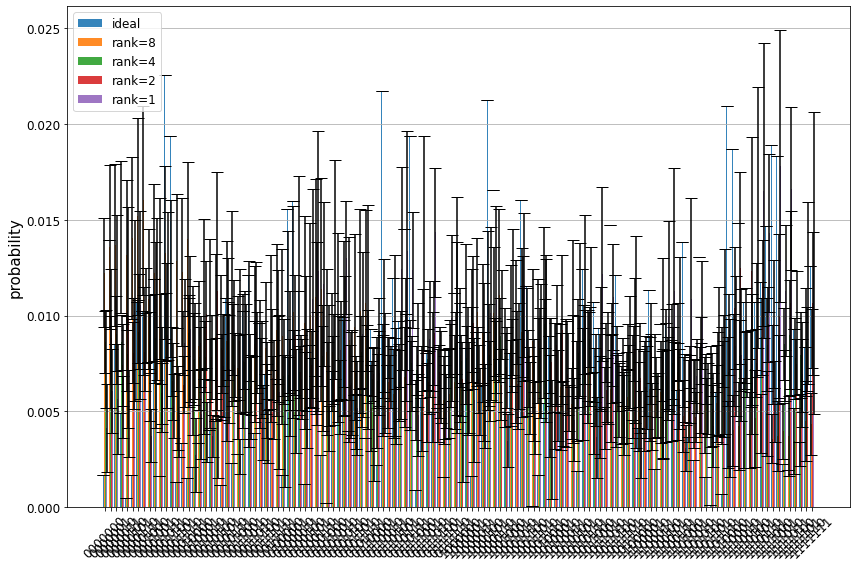

In [7]:
import numpy as np
import matplotlib.pyplot as plt
    
def plot(labels, averages, stds, xticks):
    n_bars = len(xticks)
    n_labels = len(labels)
    
    b_width = (1/n_labels)*0.75
    fig = plt.subplots(figsize = (12, 8))

    x_pos = np.arange(n_bars)
    for i, avg in enumerate(averages):
        plt.bar(x_pos, avg, yerr = stds[i], width = b_width, label = labels[i],
                align='center', alpha=0.9, ecolor='black', capsize=b_width*40)
        
        x_pos = [x + b_width for x in x_pos]
    
    plt.ylabel('probability', fontsize = 15)
    plt.xticks([x + b_width*(n_labels-1)/2 for x in range(n_bars)], xticks, fontsize=12, rotation=45)
    plt.grid(b=True, axis='y')
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    #plt.savefig('bar_plot_with_error_bars.png')
    plt.show()

def plot_result(ideal, probs):
    n = int(np.log2(len(ideal)))
    labels   = [ "rank="+str(key) for key, val in probs.items() ]
    averages = [ np.mean(prob, axis=0) for key, prob in probs.items() ]
    stds     = [ np.std(prob , axis=0) for key, prob in probs.items() ]
    xticks   = ['{:0{}b}'.format(p, n) for p in range(2**n)]

    labels.insert(0, 'ideal')
    averages.insert(0, ideal)
    stds.insert(0, [0]*len(ideal))

    plot(labels, averages, stds, xticks)
    
for n in n_list:
    print('n =', n)
    for j, backend in enumerate(backends):
        print('backend =', backend.name())
        plot_result(ideals[n], result[n][backend.name()])